In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_08 import *

# Optimizer tweaks 

## Imagenette data 

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [4]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 128

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(
    il, partial(grandparent_splitter, valid_name="val"))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [5]:
nfs = [32,64,128,256]

In [6]:
cbfs = [partial(AvgStatsCallback, accuracy), CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [7]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [8]:
run.fit(1, learn)

train: [1.7197324700442067, tensor(0.4093, device='cuda:0')]
valid: [1.5588280029296875, tensor(0.4780, device='cuda:0')]


In [9]:
compose??

In [10]:
class Optimizer:
    def __init__(self, params, steppers, **defaults):
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list):
            self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]
        self.steppers = listify(steppers)
        
    def grad_params(self):
        return [(p, hyper) for pg, hyper in zip(self.param_groups, self.hypers)
                for p in pg if p.grad is not None]
        
    def zero_grad(self):
        for p, hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
        
    def step(self):
        for p, hyper in self.grad_params():
            compose(p, self.steppers, **hyper)

In [11]:
#export
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data) #multiply then add
    return p

In [12]:
opt_func = partial(Optimizer, steppers=[sgd_step])

In [13]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs):
        self.pname,self.sched_funcs = pname,listify(sched_funcs)

    def begin_batch(self): 
        if not self.in_train: return
        fs = self.sched_funcs
        if len(fs)==1: fs = fs*len(self.opt.param_groups)
        pos = self.n_epochs/self.epochs
        for f,h in zip(fs,self.opt.hypers): h[self.pname] = f(pos)
            
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.hypers: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [14]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

In [15]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, Recorder,
        partial(ParamScheduler, 'lr', sched)]

In [16]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=opt_func)

In [17]:
%time run.fit(1, learn)

train: [1.7237662624088723, tensor(0.4134, device='cuda:0')]
valid: [1.239428466796875, tensor(0.6060, device='cuda:0')]
CPU times: user 5.11 s, sys: 1.91 s, total: 7.03 s
Wall time: 7.45 s


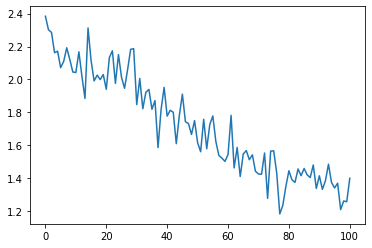

In [18]:
run.recorder.plot_loss()

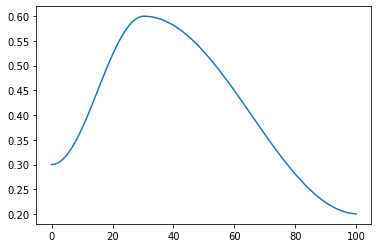

In [19]:
run.recorder.plot_lr()

## Weight decay 

In [20]:
for k, pg in enumerate(list(learn.model.parameters())):
    if k != 0:
        continue
        
    i = 0
    for p in pg:
        print(p.shape, p.grad)
        i += 1
    break
print(i)

torch.Size([3, 3, 3]) None
torch.Size([3, 3, 3]) None
torch.Size([3, 3, 3]) None
torch.Size([3, 3, 3]) None
torch.Size([3, 3, 3]) None
torch.Size([3, 3, 3]) None
torch.Size([3, 3, 3]) None
torch.Size([3, 3, 3]) None
torch.Size([3, 3, 3]) None
torch.Size([3, 3, 3]) None
torch.Size([3, 3, 3]) None
torch.Size([3, 3, 3]) None
torch.Size([3, 3, 3]) None
torch.Size([3, 3, 3]) None
torch.Size([3, 3, 3]) None
torch.Size([3, 3, 3]) None
16


In [21]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=Fa

In [22]:
#export
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1 - lr*wd)
    return p
weight_decay._defaults = dict(wd=0.)

In [23]:
#export
def l2_reg(p, lr, wd, **kwargs):
    p.grad.data.add_(wd, p.data)
    return p
l2_reg._defaults = dict(wd=0.)

In [24]:
#export
def maybe_update(os, dest, f):
    for o in os:
        for k, v in f(o).items():
            if k not in dest: dest[k] = v
            
def get_defaults(d): return getattr(d, '_defaults', {})

In [25]:
#export
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]

    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [26]:
#export 
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

In [27]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=sgd_opt)

In [28]:
model = learn.model

In [29]:
opt = sgd_opt(model.parameters(), lr=0.1)
test_eq(opt.hypers[0]['wd'], 0.)
test_eq(opt.hypers[0]['lr'], 0.1)

In [30]:
opt = sgd_opt(model.parameters(), lr=0.1, wd=1e-4)
test_eq(opt.hypers[0]['wd'], 1e-4)
test_eq(opt.hypers[0]['lr'], 0.1)

In [31]:
cbfs = [partial(AvgStatsCallback,accuracy), CudaCallback]

In [32]:
learn,run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=partial(sgd_opt, wd=0.01))

In [33]:
run.fit(1, learn)

train: [1.7233113815049637, tensor(0.4023, device='cuda:0')]
valid: [3.07823681640625, tensor(0.1680, device='cuda:0')]


## With momentum 

In [34]:
#export
class StatefulOptimizer(Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults):
        self.stats = listify(stats)
        maybe_update(self.stats, defaults, get_defaults)
        super().__init__(params, steppers, **defaults)
        self.state = {}
        
    def step(self):
        for p,hyper in self.grad_params():
            if p not in self.state:
                # Create a state for p and call all the statistics 
                
                self.state[p] = {}
                maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
                
            state = self.state[p]
            for stat in self.stats: state = stat.update(p, state, **hyper)
            compose(p, self.steppers, **state, **hyper)
            self.state[p] = state
            

In [35]:
#export
class Stat:
    _defaults = {}
    def ini_state(self, p): raise NotImplementedError
    def update(self, p, state, **kwargs): raise NotImplementedError

In [36]:
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    
    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state["grad_avg"].mul_(mom).add_(p.grad.data)
        return state

In [37]:
#export
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg)
    return p

In [38]:
sgd_mom_opt = partial(StatefulOptimizer, steppers=[momentum_step, weight_decay],
                     stats=AverageGrad(), wd=0.01)

In [39]:
learn, run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs,
                          opt_func=sgd_mom_opt)

In [40]:
run.fit(1, learn)

train: [1.8969269863890181, tensor(0.3612, device='cuda:0')]
valid: [2.027984130859375, tensor(0.3340, device='cuda:0')]


### Momentum experiments 

In [41]:
x = torch.linspace(-4, 4, 200)
y = torch.randn(200) + 0.3
betas = [0.5, 0.7, 0.9, 0.99]

In [42]:
def plot_mom(f):
    _, axes = plt.subplots(2,2,figsize=(12,8))
    for beta, ax in zip(betas, axes.flatten()):
        ax.plot(y, linestyle='None', marker='.')
        avg, res = None, []
        for i, yi in enumerate(y):
            avg, p = f(avg, beta, yi, i)
            res.append(p)
        ax.plot(res, color='red')
        ax.set_title(f'beta={beta}')

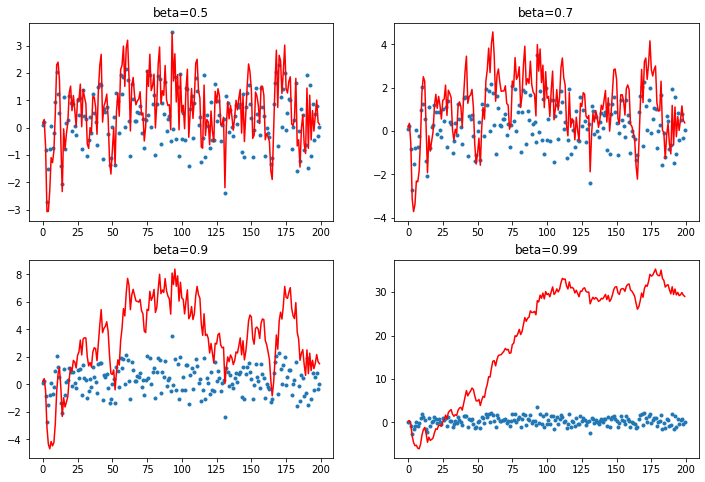

In [43]:
def mom1(avg, beta, yi, i):
    if avg is None: avg=yi
    res = beta*avg + yi
    return res, res
plot_mom(mom1)

In [44]:
#export
def lin_comb(v1, v2, beta): return beta*v1 + (1-beta)*v2

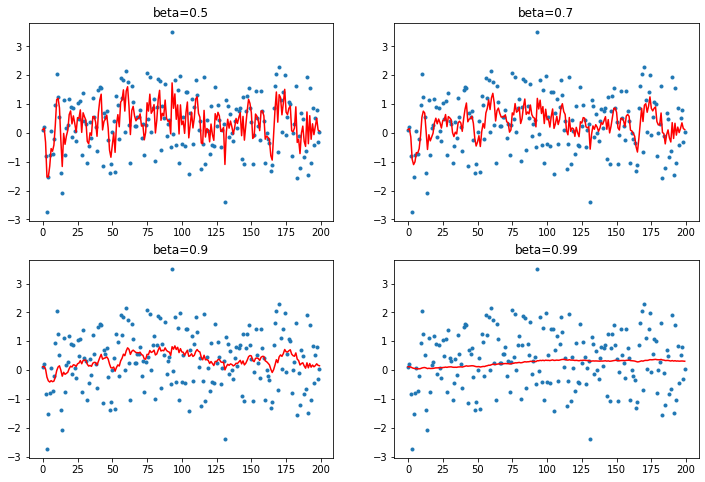

In [45]:
def mom2(avg, beta, yi, i):
    if avg is None: avg = yi
    avg = lin_comb(avg, yi, beta)
    return avg, avg
plot_mom(mom2)

In [46]:
y = 1 - (x/3)**2 + torch.randn(200)*0.1

In [47]:
y[0] = 0.5

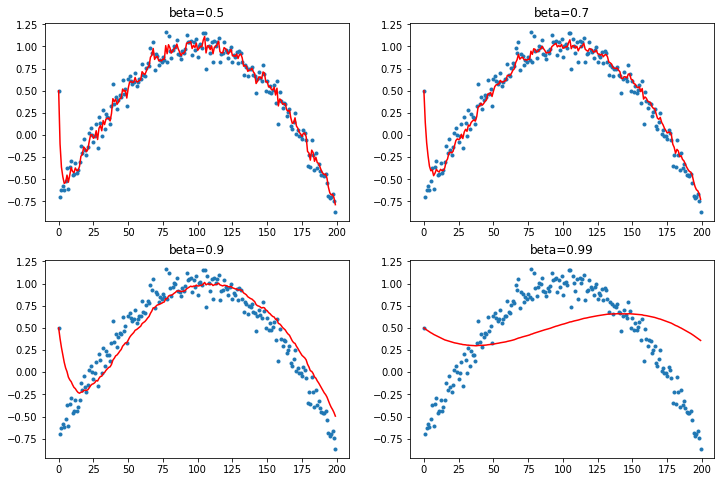

In [48]:
plot_mom(mom2)

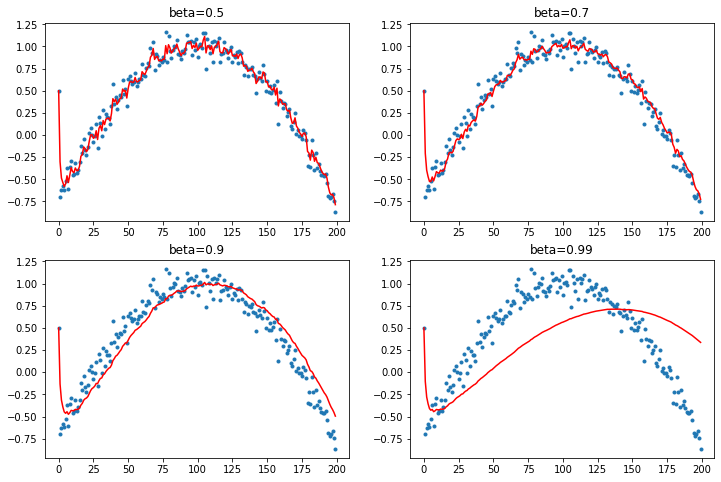

In [49]:
def mom3(avg, beta, yi, i):
    if avg is None: avg=0
    avg = lin_comb(avg, yi, beta)
    return avg, avg/(1-beta**(i+1))
plot_mom(mom3)

### Adam with friends 

In [50]:
#export
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    
    def __init__(self, dampening:bool=False): self.dampening=dampening
    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state["mom_damp"] = 1-mom if self.dampening else 1.
        state["grad_avg"].mul_(mom).add_(state["mom_damp"], p.grad.data)
        return state

In [51]:
#export
class AverageSqrGrad(Stat):
    _defaults = dict(sqr_mom=0.99)
    
    def __init__(self, dampening:bool=True): self.dampening=dampening
    def init_state(self, p): return {'sqr_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, sqr_mom, **kwargs):
        state['sqr_damp'] = 1-sqr_mom if self.dampening else 1.
        state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], p.grad.data, p.grad.data)
        return state

In [52]:
#export
class StepCount(Stat):
    def init_state(self, p): return {"step": 0}
    def update(self, p, state, **kwargs):
        state['step'] += 1
        return state

In [53]:
#export
def debias(mom, damp, step): return damp * (1-mom**step)/(1-mom)

In [54]:
#export
def adam_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    p.data.addcdiv_(-lr / debias1, grad_avg, (sqr_avg/debias2).sqrt() + eps)
    return p
adam_step._defaults = dict(eps=1e-5)

In [55]:
#export
def adam_opt(xtra_step=None, **kwargs):
    return partial(StatefulOptimizer, steppers=[adam_step,weight_decay]+listify(xtra_step),
                   stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()], **kwargs)

In [56]:
learn,run = get_learn_run(nfs, data, 0.001, conv_layer, cbs=cbfs, opt_func=adam_opt())

In [57]:
run.fit(3, learn)

train: [1.6317712574647123, tensor(0.4456, device='cuda:0')]
valid: [1.311631591796875, tensor(0.5740, device='cuda:0')]
train: [1.146183468934194, tensor(0.6210, device='cuda:0')]
valid: [1.1545068359375, tensor(0.6180, device='cuda:0')]
train: [0.8776810404790988, tensor(0.7181, device='cuda:0')]
valid: [1.062522216796875, tensor(0.6600, device='cuda:0')]


In [58]:
def lamb_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, wd, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    r1 = p.data.pow(2).mean().sqrt()
    step = (grad_avg/debias1) / ((sqr_avg/debias2).sqrt()+eps) + wd*p.data
    r2 = step.pow(2).mean().sqrt()
    p.data.add_(-lr * min(r1/r2,10), step)
    return p
lamb_step._defaults = dict(eps=1e-6, wd=0.)

In [59]:
lamb = partial(StatefulOptimizer, steppers=lamb_step, stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()])

In [60]:
learn,run = get_learn_run(nfs, data, 0.003, conv_layer, cbs=cbfs, opt_func=lamb)

In [61]:
run.fit(3, learn)

train: [1.7842261904761905, tensor(0.3878, device='cuda:0')]
valid: [1.424049560546875, tensor(0.5140, device='cuda:0')]
train: [1.241063627583566, tensor(0.5947, device='cuda:0')]
valid: [1.281967529296875, tensor(0.5860, device='cuda:0')]
train: [0.9443532814438886, tensor(0.6949, device='cuda:0')]
valid: [1.07269921875, tensor(0.6480, device='cuda:0')]


## Export 

In [62]:
!python notebook2script.py 09_optimizers.ipynb

Converted 09_optimizers.ipynb to exp/nb_09.py
